# Ensembling

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

In [18]:
from IPython.display import Image
%matplotlib inline 

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Define ensembling and its requirements
- Identify the two basic methods of ensembling
- Decide whether manual ensembling is a useful approach for a given problem
- Explain bagging and how it can be applied to decision trees
- Explain how out-of-bag error and feature importances are calculated from bagged trees
- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Introduction

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [19]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [20]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print(ensemble_preds[:20])

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [21]:
# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.713
0.665
0.717
0.712
0.687


In [22]:
# how accurate was the ensemble?
print(ensemble_preds.mean())

0.841


**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you

# Part 2: Manual ensembling

What makes a good manual ensemble?

- Different types of **models**
- Different combinations of **features**
- Different **tuning parameters**

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

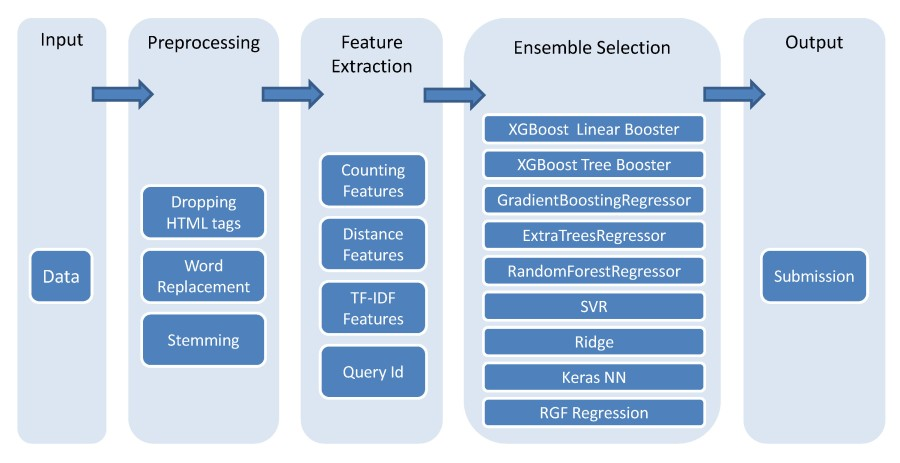

In [23]:
Image("../../assets/images/crowdflower_ensembling.jpg")

## Comparing manual ensembling with a single model approach

**Advantages of manual ensembling:**

- Increases predictive accuracy
- Easy to get started

**Disadvantages of manual ensembling:**

- Decreases interpretability
- Takes longer to train
- Takes longer to predict
- More complex to automate and maintain
- Small gains in accuracy may not be worth the added complexity

# Part 3: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

In [24]:
# set a seed for reproducibility
np.random.seed(1234)

# create an array of 1 through 20
nums = np.arange(1, 21)
print(nums)

# sample that array 20 times with replacement
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[16 20  7 13 16 18 10 12 13 17  6 17 10 16 19 17 13  6  3  7]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times and averaging the results.

## Manually implementing bagged decision trees (with B=10)

In [25]:
# read in and prepare the vehicle training data
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [26]:
# set a seed for reproducibility
np.random.seed(123)

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [27]:
# show the rows for the first decision tree
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [28]:
# read in and prepare the vehicle testing data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [29]:
from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted price from each tree
predictions = []

# define testing data
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[ 1300.,  5000., 14000.],
       [ 1300.,  1300., 13000.],
       [ 3000.,  3000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 1300.,  5000., 13000.],
       [ 4000.,  5000., 14000.],
       [ 4000.,  4000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 3000.,  5000.,  9500.],
       [ 4000.,  5000.,  9000.]])

In [30]:
# average predictions
np.mean(predictions, axis=0)

array([ 2990.,  4330., 12450.])

In [31]:
# calculate RMSE
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.5823284370031

## Bagged decision trees in scikit-learn (with B=500)

In [32]:
# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [33]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1234)

In [34]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3305.4,  5138.8, 13106. ])

In [35]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

828.2854982834522

## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [36]:
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [37]:
# show the "in-bag" observations for each sample
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [38]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print(sorted(set(range(14)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [39]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.8098699358727273

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees

# Part 4: Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Part 5: Building and tuning decision trees and Random Forests

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player
- **Goal:** Predict player salary

## Preparing the data

In [40]:
# read in the data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/hitters.csv'
hitters = pd.read_csv(url)

# remove rows with missing values
hitters.dropna(inplace=True)

In [41]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [42]:
# encode categorical variables as integers
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [43]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

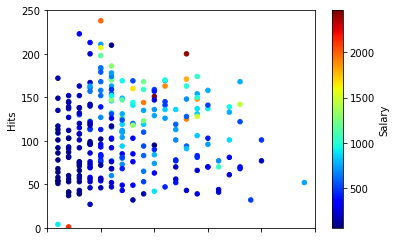

In [44]:
# scatter plot of Years versus Hits colored by Salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250))

In [45]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [51]:
# define X and y
X = hitters[feature_cols]
y = hitters.Salary

## Predicting salary with a decision tree

Find the best **max_depth** for a decision tree using cross-validation:

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# create a list of values to try for max_depth - start with 1 to 20
max_depth = [v for v in range(1,21)]

# create a list to store the average RMSE for each value of max_depth
rmse= []

# use 10-fold cross-validation with each value of max_depth
for max_ in max_depth:
dtr = hitters.DecisionTreeRegressor(max_depth=max_)

cv = cross_val_score(tm, X, y, cv=10, scoring='neg_mean_squared_error')

# use mse as the scoring metric



AttributeError: 'DataFrame' object has no attribute 'DecisionTreeRegressor'

In [ ]:
# plot max_depth (x-axis) versus RMSE (y-axis)

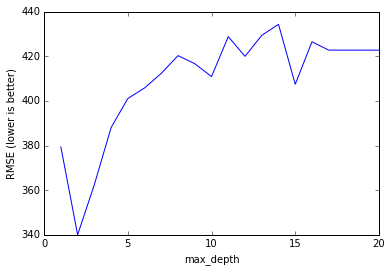

In [29]:
# Answer - should look like below graph

In [30]:
# show the best RMSE and the corresponding max_depth
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.03416870475201, 2)

In [31]:
# max_depth=2 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [32]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values('importance')

,feature,importance
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000
10,Assists,0.000000
11,Errors,0.000000


## Predicting salary with a Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [45]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0,0.5,'RMSE (lower is better)')

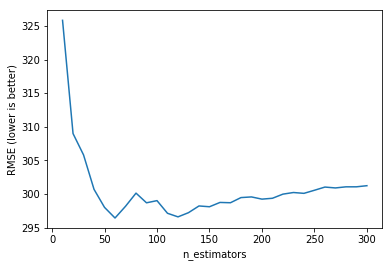

In [46]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [49]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0,0.5,'RMSE (lower is better)')

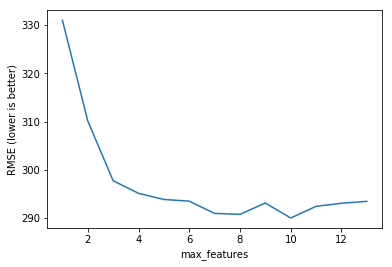

In [48]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [38]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]

(288.41877774269841, 8)

### Fitting a Random Forest with the best parameters

In [39]:
# max_features=8 is best and n_estimators=150 is sufficiently large
rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [40]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values('importance')

,feature,importance
7,League,0.003402
12,NewLeague,0.003960
8,Division,0.007253
10,Assists,0.024857
11,Errors,0.026147
2,HmRun,0.041620
9,PutOuts,0.058637
3,Runs,0.070350
0,AtBat,0.096424
4,RBI,0.133953


In [41]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

0.53646364056364049

### Reducing X to its most important features

In [42]:
# check the shape of X
X.shape

(263, 13)

In [43]:
# set a threshold for which features to include
print(rfreg.transform(X, threshold=0.1).shape)
print(rfreg.transform(X, threshold='mean').shape)
print(rfreg.transform(X, threshold='median').shape)

(263L, 4L)
(263L, 5L)
(263L, 7L)


In [44]:
# create a new feature matrix that only includes important features
X_important = rfreg.transform(X, threshold='mean')

In [45]:
# check the RMSE for a Random Forest that only includes important features
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

284.82790842153145

## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

*Machine learning flowchart created by the [second place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*

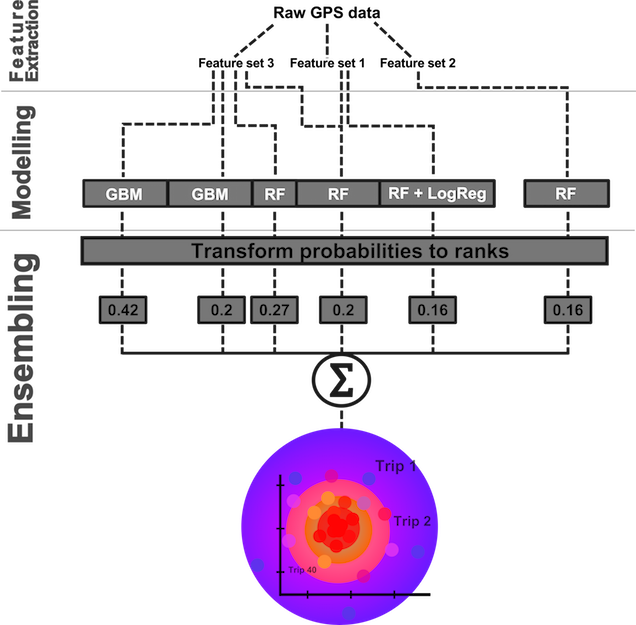

In [56]:
Image("../../assets/images/driver_ensembling.png")